 Import Necessary Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D ,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50  # For transfer learning
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
import cv2

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')  # just limit the use of tenserflow
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu ,True)

Data Loading and Preprocessing

In [3]:
# Hyperparameters
img_height, img_width = (224, 224)
batch_size = 32
epochs = 20
learning_rate = 0.001

# Data paths
train_dir = 'Training'
val_dir = 'Validation'
test_dir = 'Testing'

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2, 

    horizontal_flip=True,
    fill_mode='reflect' 

)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical' 

)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width), 

    batch_size=batch_size,
    class_mode='categorical' 

)



Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [4]:
len(train_generator)

97

Visualization

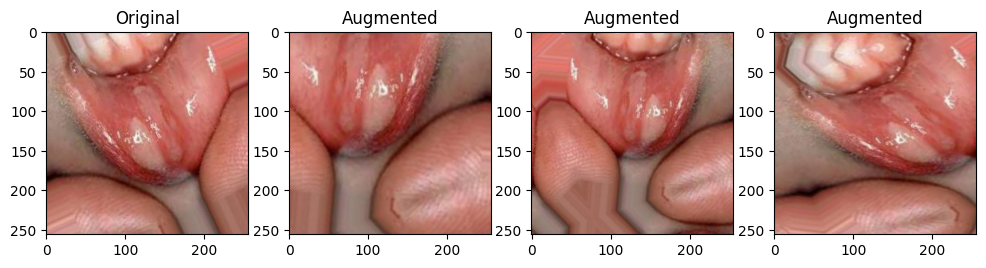

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def visualize_augmentation(img, datagen):
    # Convert image to a batch
    x = np.expand_dims(img, axis=0) / 255.0  # Normalize image

    # Create an iterator from the generator
    generator = datagen.flow(x, batch_size=1)

    # Plot original and augmented images
    fig, ax = plt.subplots(1, 4, figsize=(12, 3))
    ax[0].imshow(img)
    ax[0].set_title('Original')

    for i in range(3):
        batch = next(generator)
        augmented_img = batch[0]  # Remove .astype('uint8') to preserve float values
        ax[i+1].imshow(augmented_img)
        ax[i+1].set_title('Augmented')

    plt.show()

# Load your image (replace with your image path)
img = cv2.imread('Training\\CaS\\a_79_0_707.jpg')
if img is not None:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create an ImageDataGenerator
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect'
  # or 'wrap'
    )

    # Visualize augmentation
    visualize_augmentation(img, datagen)
else:
    print("Error loading image:", img)

Class distribution

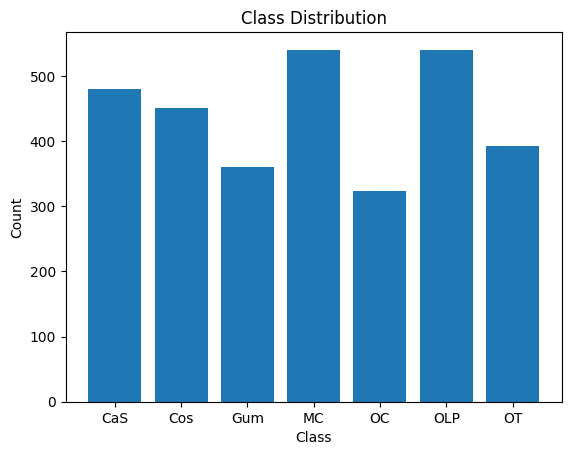

In [21]:
# Class distribution no of image in each folder
import matplotlib.pyplot as plt
def count_images_per_class(data_dir):
    class_counts = {}
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path): 
    # Check if it's a directory (class)
            images = os.listdir(class_path)  # Get list of files (images) within the class
            class_counts[class_name] = len(images)  # Count images and store in dictionary
    return class_counts

class_counts = count_images_per_class(train_dir)
plt.bar(range(len(class_counts)), list(class_counts.values()))
plt.xticks(range(len(class_counts)), ['CaS', 'Cos', 'Gum','MC','OC','OLP','OT'])  # Replace with actual class names
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

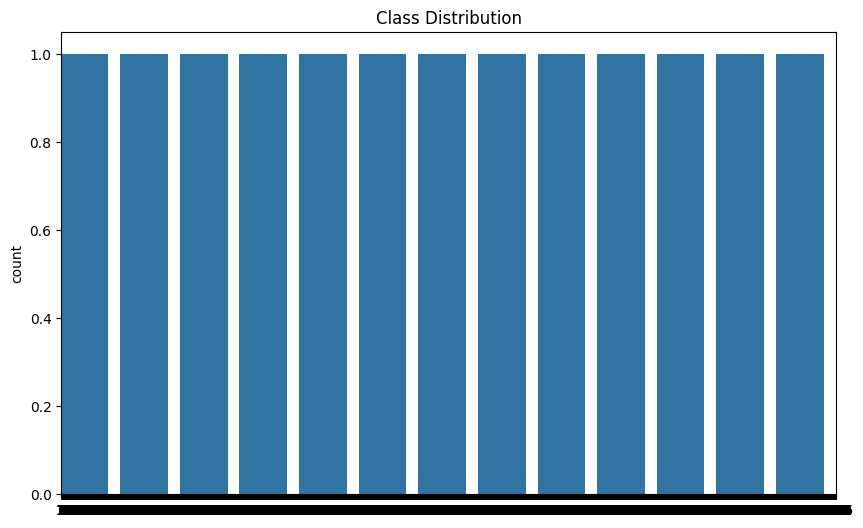

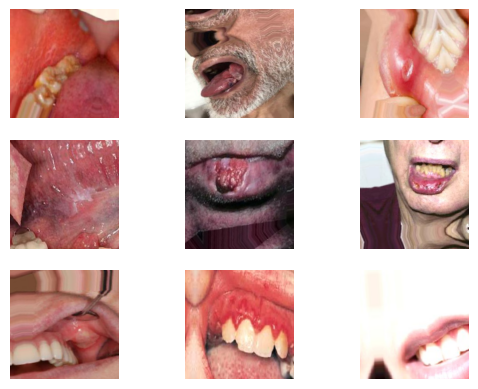

In [22]:
# Class distribution
plt.figure(figsize=(10, 6))
sns.countplot(train_generator.classes)
plt.title('Class Distribution')
plt.show()

# Sample images before and after augmentation
img, label = next(train_generator)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img[i])
    plt.axis('off')
plt.show()

Model Architecture and Training

In [6]:
# Create the model
model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(7, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Adjust learning rate if needed
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 


# Early stopping
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

# Train the model
history = model.fit(
    train_generator,
    epochs=40,  
    # Adjust epochs as needed
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
#    callbacks=[early_stopping]
)


C:\Users\demia\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 7), output.shape=(None, 222, 222, 7)

In [ ]:
#logdir='logs'
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
#hist = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[tensorboard_callback])

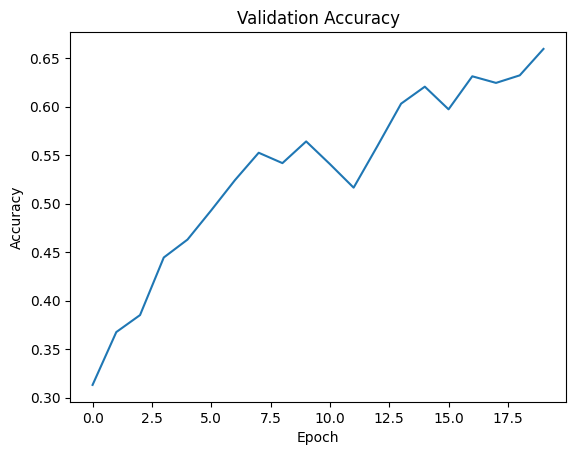

In [6]:
# Access validation accuracy
val_acc = history.history['val_accuracy']

# Plot validation accuracy
plt.plot(val_acc)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [7]:
val_acc = history.history['val_accuracy']

# Print the final validation accuracy
print("Final validation accuracy:", val_acc[-1])

Final validation accuracy: 0.6595330834388733


In [8]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Generate predictions
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate classification report
print(classification_report(y_true, y_pred_classes))

# Calculate confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
print(confusion_mtx)

 1/33 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.6875 - loss: 1.0607

C:\Users\demia\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step - accuracy: 0.6665 - loss: 0.9964
Test accuracy: 0.6410505771636963
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step
              precision    recall  f1-score   support

           0       0.14      0.18      0.16       160
           1       0.15      0.20      0.17       149
           2       0.08      0.06      0.07       120
           3       0.19      0.24      0.21       180
           4       0.13      0.07      0.10       108
           5       0.20      0.17      0.18       180
           6       0.13      0.09      0.11       131

    accuracy                           0.15      1028
   macro avg       0.15      0.14      0.14      1028
weighted avg       0.15      0.15      0.15      1028

[[29 32 11 37 15 23 13]
 [28 30 18 31  8 24 10]
 [24 26  7 32  4 14 13]
 [47 29 14 43  9 21 17]
 [16 28 10 20  8 14 12]
 [46 25 19 35 12 30 13]
 [23 31 14 25  4 22 12]]


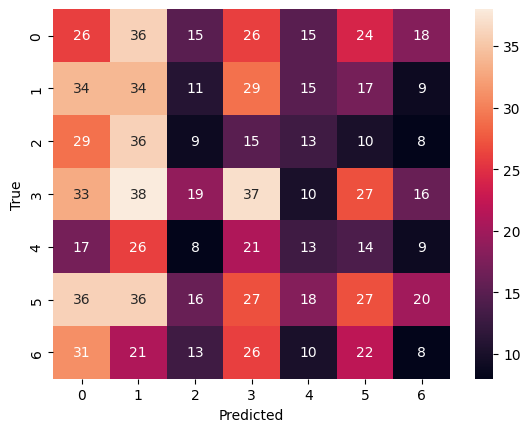

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()